In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2  
from tqdm import tqdm
from random import randint
import json
import matplotlib.image as mpimg
from matplotlib import rcParams
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

Using TensorFlow backend.


In [3]:
train_path = "data/train"
test_path = "data/test"

train = os.listdir(train_path)
test = os.listdir(test_path)

In [4]:
train_feature = pd.read_csv("data/train_features.csv")
test_feature = pd.read_csv("data/test_features.csv")

In [5]:
train_image = [cv2.cvtColor(cv2.imread(os.path.join(train_path, image)), cv2.COLOR_BGR2RGB)  for image in train ]

In [6]:
test_image = [cv2.cvtColor(cv2.imread(os.path.join(test_path, image)), cv2.COLOR_BGR2RGB)  for image in test ]

In [7]:
trian_label = pd.read_csv("data/imagenames.csv")


# load the model
model = ResNet50(weights='imagenet')

In [8]:
test_object = {}

for i in tqdm(range(len(test))):
    imgpath = test_path+"/"+test[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    k_img = preprocess_input(img)
    preds = model.predict(k_img)

    test_object[test[i]] = {}
    detect_object = [pred[1] for pred in decode_predictions(preds, top=5)[0]]
    detect_weight = [pred[2] for pred in decode_predictions(preds, top=5)[0]]

    test_object[test[i]]["detect_object"] = detect_object
    test_object[test[i]]["detect_weight"] = detect_weight

100%|██████████| 1200/1200 [01:00<00:00, 19.95it/s]


In [9]:
train_object = {}

for i in tqdm(range(len(train))):
    imgpath = train_path+"/"+train[i]
    img = image.load_img(imgpath, target_size=(224, 224))
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    k_img = preprocess_input(img)
    preds = model.predict(k_img)

    train_object[train[i]] = {}
    detect_object = [pred[1] for pred in decode_predictions(preds, top=5)[0]]
    detect_weight = [pred[2] for pred in decode_predictions(preds, top=5)[0]]

    train_object[train[i]]["detect_object"] = detect_object
    train_object[train[i]]["detect_weight"] = detect_weight

100%|██████████| 7500/7500 [05:26<00:00, 22.97it/s]


# Concat 的图片做object好像不太好orz

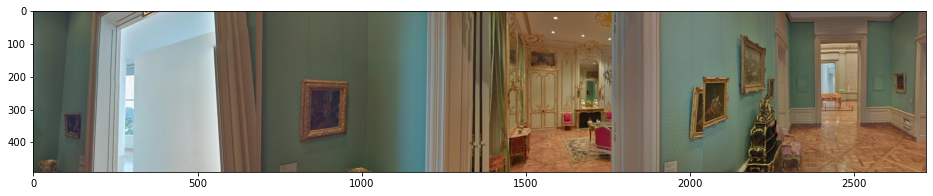

In [32]:
image = list(d.keys())[3]
plt.figure(figsize=(16, 12))
plt.imshow(d[image], cmap='gray')
plt.show()

# without concat

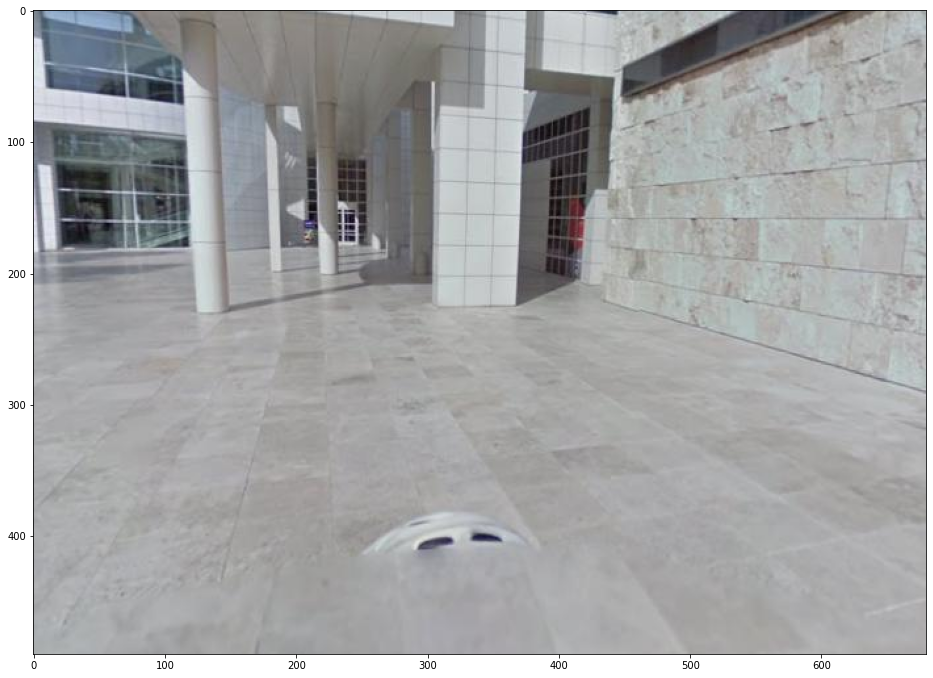

{'detect_object': ['patio', 'prison', 'sliding_door', 'vault', 'library'],
 'detect_weight': [0.46232113,
  0.09355818,
  0.086918205,
  0.08611194,
  0.063039064]}

In [12]:
index = 3
image = train[index]
plt.figure(figsize=(16, 12))
plt.imshow(train_image[index], cmap='gray')
plt.show()
train_object[image]

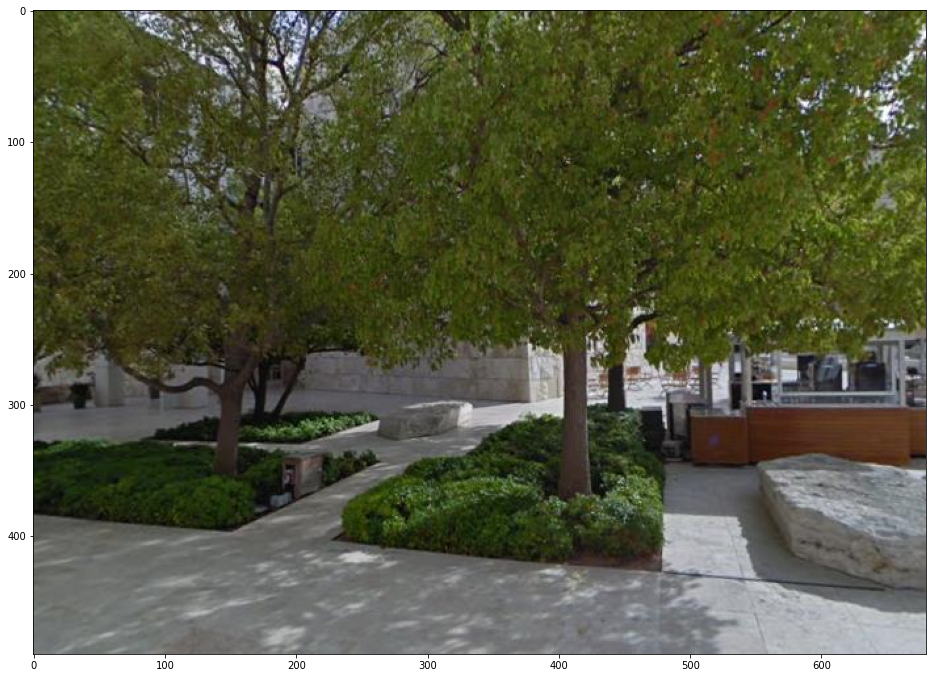

{'detect_object': ['patio', 'lakeside', 'bannister', 'mobile_home', 'pot'], 'detect_weight': [0.55550367, 0.14606841, 0.02315452, 0.021269077, 0.017995983]}


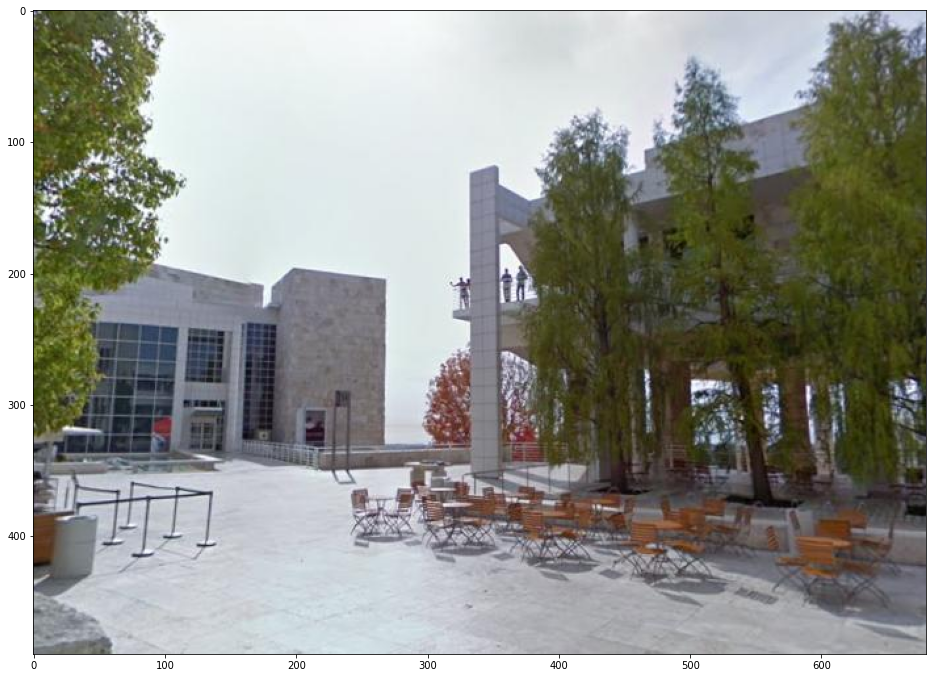

{'detect_object': ['lakeside', 'fountain', 'snowplow', 'cab', 'patio'], 'detect_weight': [0.19941574, 0.09212202, 0.072471015, 0.0568857, 0.052829027]}


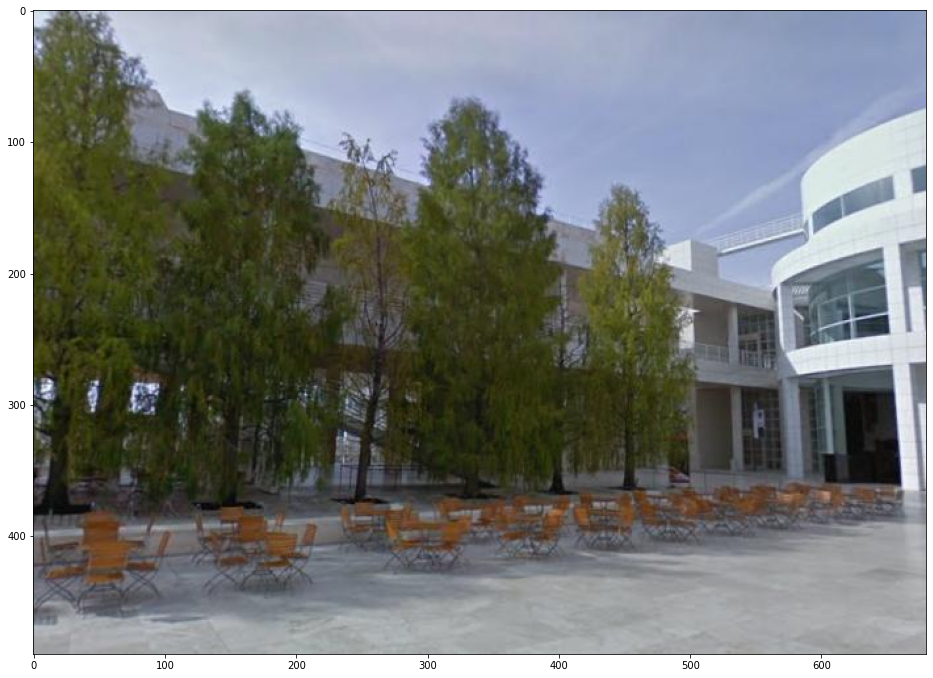

{'detect_object': ['planetarium', 'recreational_vehicle', 'patio', 'dome', 'mobile_home'], 'detect_weight': [0.19644175, 0.1865821, 0.16192935, 0.14595151, 0.06281069]}


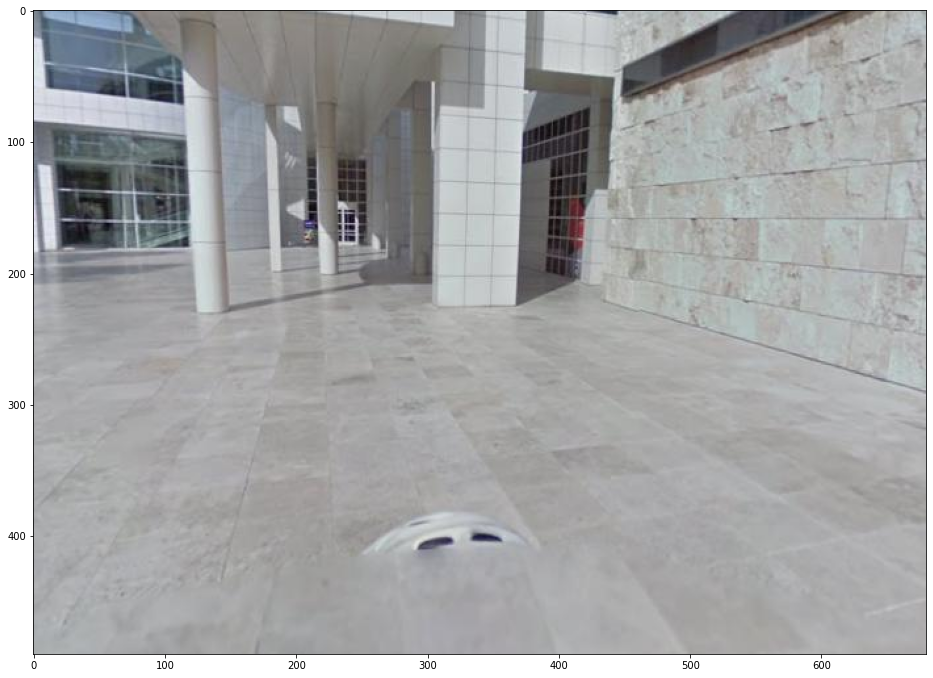

{'detect_object': ['patio', 'prison', 'sliding_door', 'vault', 'library'], 'detect_weight': [0.46232113, 0.09355818, 0.086918205, 0.08611194, 0.063039064]}


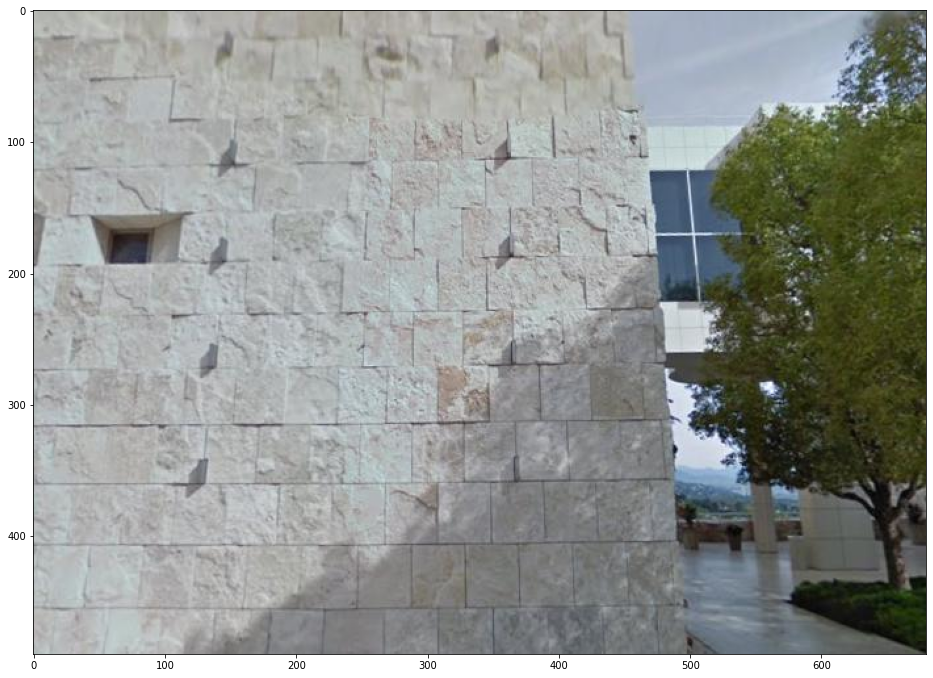

{'detect_object': ['cliff_dwelling', 'obelisk', 'beacon', 'bell_cote', 'triumphal_arch'], 'detect_weight': [0.43245342, 0.3471469, 0.04938328, 0.031747367, 0.021947643]}


In [15]:
for i in range(5):
    image = train[i]
    plt.figure(figsize=(16, 12))
    plt.imshow(train_image[i], cmap='gray')
    plt.show()
    print(train_object[image])

In [129]:
from collections import defaultdict
d = defaultdict(lambda: {})

In [130]:
for i in tqdm(range(len(train))): 
    img = train[i]
    cluster = train_feature["cluster"][i]
    for j in range(5):
        d[cluster][train_object[img]['detect_object'][j]] = 0


100%|██████████| 7500/7500 [00:00<00:00, 138856.65it/s]


In [131]:
for i in tqdm(range(len(train))): 
    img = train[i]
    cluster = train_feature["cluster"][i]
    for j in range(5):
        d[cluster][train_object[img]['detect_object'][j]] += train_object[img]['detect_weight'][j]


100%|██████████| 7500/7500 [00:00<00:00, 59986.50it/s]


In [132]:
test = d.copy()

In [133]:
for key in test.keys():
    test[key] = {k: v for k, v in sorted(test[key].items(), key=lambda item: item[1],reverse=True)}

In [134]:
for key in test.keys():
    item = list(test[key].keys())[0]
    if test[key][item] > 1:
        test[key] = item
    else:
        test[key] = "Unknow"


In [171]:
import collections

counter=collections.Counter(list(test.values() ))
del counter["Unknow"]
counter = {k: v for k, v in sorted(counter.items(), key=lambda item: item[1],reverse=True)}

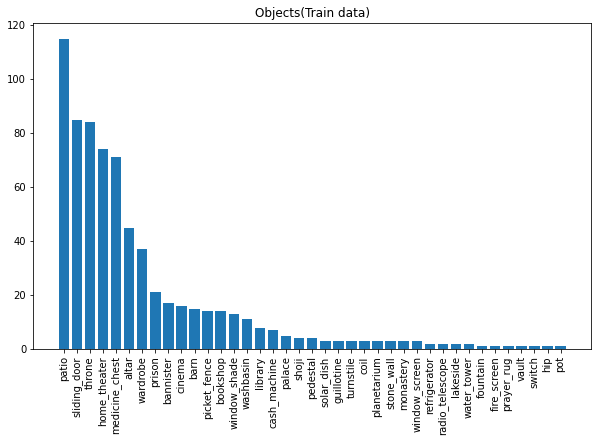

In [172]:
plt.figure(figsize=(10,6))
plt.bar(counter.keys(),counter.values())
plt.xticks(rotation = 90)
plt.title("Objects(Train data)")
plt.savefig("image/train object.png")
plt.show()

In [139]:
d_test = defaultdict(lambda: {})

In [140]:
for i in test_object.keys(): 
    for j in range(len(test_object[i]['detect_object'])):
        item = test_object[i]['detect_object'][j]
        d_test[i][item] = test_object[i]['detect_weight'][j]

In [178]:
test2 = d_test.copy()
for key in test2.keys():
    item = list(test2[key].keys())[0]
    if test2[key][item] > 0.3:
        test2[key] = item

    else:
        test2[key] = "Unknow"


In [179]:
counter2=collections.Counter(list(test2.values() ))
del counter2["Unknow"]
counter2 = {k: v for k, v in sorted(counter2.items(), key=lambda item: item[1],reverse=True)}

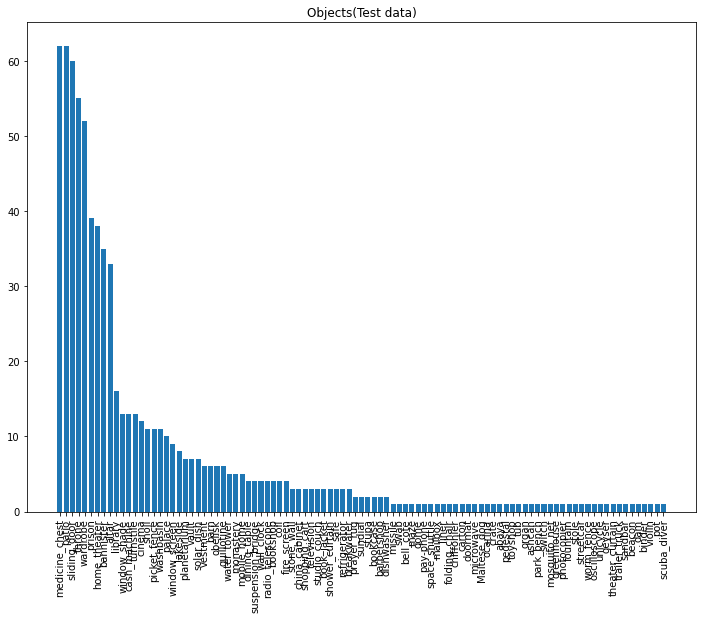

In [269]:
plt.figure(figsize=(12,9))
plt.bar(counter2.keys(),counter2.values())
plt.xticks(rotation = 90)
plt.title("Objects(Test data)")
plt.savefig("image/test object.png")
plt.show()

In [260]:
count_train =  pd.DataFrame(counter,index=[0]).T
count_test =  pd.DataFrame(counter2,index=[0]).T

count_train.reset_index(inplace=True)
count_test.reset_index(inplace=True)

In [261]:
count_train = count_train.merge(count_test,left_on="index",right_on= "index")
count_train = count_train.rename(columns={'index': 'object','0_x': 'train','0_y': 'test'})

In [262]:
count_train

object  train  test
0             patio    115    62
1      sliding_door     85    60
2            throne     84    55
3      home_theater     74    38
4    medicine_chest     71    62
5             altar     45    33
6          wardrobe     37    52
7            prison     21    39
8         bannister     17    35
9            cinema     16    12
10             barn     15     6
11     picket_fence     14    11
12         bookshop     14     4
13     window_shade     13    13
14        washbasin     11    11
15          library      8    16
16     cash_machine      7    13
17           palace      5    10
18            shoji      4    11
19         pedestal      4     1
20       solar_dish      3     7
21       guillotine      3     6
22        turnstile      3    13
23             coil      3     4
24      planetarium      3     7
25       stone_wall      3     3
26        monastery      3     5
27    window_screen      3     9
28     refrigerator      2     3
29  radio_telescope      2     4
30         lakeside      2     8
31      water_tower      2     5
32         fountain      1     1
33      fire_screen      1     4
34       prayer_rug      1     2
35            vault      1     7
36           switch      1     1
37              pot      1     1

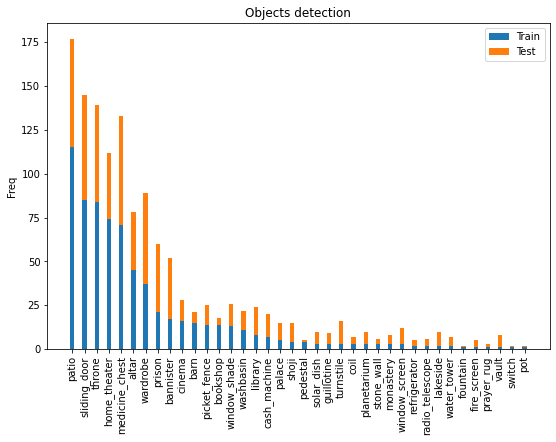

In [267]:
width = 0.35       # the width of the bars: can also be len(x) sequence

fig, ax = plt.subplots(figsize=(9,6))

ax.bar(count_train["object"], count_train["train"], width, label='Train')
ax.bar(count_train["object"], count_train["test"], width, bottom=count_train["train"],
       label='Test')

plt.xticks(rotation = 90)
ax.set_ylabel('Freq')
ax.set_title('Objects detection')
ax.legend()
plt.savefig("image/Object.png")
plt.show()

In [296]:
label_train =  pd.DataFrame(test,index=[0]).T
label_test =  pd.DataFrame(test2,index=[0]).T

label_train.reset_index(inplace=True)
label_test.reset_index(inplace=True)

In [331]:
train_feature = pd.read_csv("data/train_features.csv")
test_feature = pd.read_csv("data/test_features.csv")

In [305]:
label_test

index               0
0     IMG4287_3.jpg          Unknow
1     IMG4288_5.jpg    window_shade
2     IMG4289_5.jpg        wardrobe
3     IMG4290_4.jpg          Unknow
4     IMG4291_5.jpg         missile
...             ...             ...
1195  IMG5482_1.jpg          Unknow
1196  IMG5483_2.jpg  medicine_chest
1197  IMG5484_4.jpg           patio
1198  IMG5485_3.jpg          Unknow
1199  IMG5486_2.jpg     scuba_diver

[1200 rows x 2 columns]

In [321]:
train_feature = train_feature.merge(label_train,left_on="cluster",right_on="index", copy=False)
train_feature = train_feature.drop(columns=['index'])
train_feature = train_feature.rename(columns={"object.1": "object"})

In [325]:
train_feature = train_feature.rename(columns={"object.1": "object"})

In [326]:
train_feature.head(5)

id         x        y  \
0  IMG2744_1 -9.380678  3.58272   
1  IMG2744_2 -9.380678  3.58272   
2  IMG2744_3 -9.380678  3.58272   
3  IMG2744_4 -9.380678  3.58272   
4  IMG2744_5 -9.380678  3.58272   

                                               color  \
0  [[105.42161563 107.14448812 100.08701536]\n [ ...   
1  [[ 70.89338335  69.35952808  46.43450226]\n [2...   
2  [[102.4665223  104.16690078 106.75012681]\n [ ...   
3  [[172.34591855 173.62166457 174.12597505]\n [ ...   
4  [[176.59672634 180.22641643 181.04637214]\n [ ...   

                                        color_weight  \
0  [0.6348333333333334, 0.28917916666666665, 0.07...   
1  [0.24418333333333334, 0.383675, 0.372141666666...   
2  [0.38762083333333336, 0.21436666666666668, 0.3...   
3  [0.14006666666666667, 0.80195, 0.0579833333333...   
4  [0.5870208333333333, 0.24822083333333333, 0.16...   

                                              object  \
0  ['patio', 'lakeside', 'bannister', 'mobile_hom...   
1  ['lakeside', 'fountain', 'snowplow', 'cab', 'p...   
2  ['planetarium', 'recreational_vehicle', 'patio...   
3  ['patio', 'prison', 'vault', 'sliding_door', '...   
4  ['cliff_dwelling', 'obelisk', 'beacon', 'bell_...   

                                       object_weight  cluster  \
0  [0.5601092, 0.14016706, 0.022413984, 0.0214102...  IMG2744   
1  [0.19650029, 0.09605682, 0.07403735, 0.0641981...  IMG2744   
2  [0.19081369, 0.18522698, 0.15903644, 0.1425865...  IMG2744   
3  [0.4598027, 0.09773029, 0.08703377, 0.08668958...  IMG2744   
4  [0.41137695, 0.36667395, 0.047409043, 0.031869...  IMG2744   

   PCA_100_cluster_2_without_concat  PCA_100_cluster_20_without_concat  \
0                                 0                                  6   
1                                 0                                  3   
2                                 0                                  3   
3                                 0                                 10   
4                                 0                                  9   

   PCA_500_cluster_2_without_concat  PCA_500_cluster_20_without_concat  \
0                                 0                                 15   
1                                 0                                  0   
2                                 0                                  0   
3                                 0                                 16   
4                                 0                                  5   

   PCA_100_cluster_2_with_concat  PCA_100_cluster_20_with_concat  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   PCA_500_cluster_2_with_concat  PCA_500_cluster_20_with_concat  \
0                              0                               0   
1                              0                               0   
2                              0                               0   
3                              0                               0   
4                              0                               0   

   PCA_500_cluster_10_without_concat  PCA_500_cluster_10_with_concat object  
0                                  2                               7  patio  
1                                  2                               7  patio  
2                                  2                               7  patio  
3                                  0                               7  patio  
4                                  0                               7  patio

In [327]:
train_feature.to_csv("data/train_features.csv",index = False)

In [342]:
test_feature.insert(15, "object", label_test[0], True)

In [343]:
test_feature

id                                              color  \
0     IMG4287_3  [[ 73.6183987   65.63426149  48.97455157]\n [1...   
1     IMG4288_5  [[137.14717413 138.33202102 138.31306933]\n [2...   
2     IMG4289_5  [[175.80050757 183.23411583 156.67026194]\n [1...   
3     IMG4290_4  [[ 77.09971878  81.18058383  43.14020676]\n [2...   
4     IMG4291_5  [[119.37971298 122.01727819 122.79116501]\n [1...   
...         ...                                                ...   
1195  IMG5482_1  [[129.78609983 127.33521057 123.53794097]\n [1...   
1196  IMG5483_2  [[114.87391959 107.25219356 101.11700607]\n [ ...   
1197  IMG5484_4  [[162.45384074 169.47622777 181.3246514 ]\n [ ...   
1198  IMG5485_3  [[ 88.79073834  53.05914677  19.60230792]\n [1...   
1199  IMG5486_2  [[ 39.63772977  67.00993663  74.71959665]\n [1...   

                                                 weight          object  \
0     [0.4972, 0.23238333333333333, 0.2704166666666667]          Unknow   
1     [0.5061833333333333, 0.17682083333333334, 0.31...    window_shade   
2     [0.33195416666666666, 0.6221166666666667, 0.04...        wardrobe   
3     [0.07971666666666667, 0.3940458333333333, 0.52...          Unknow   
4     [0.5002416666666667, 0.3787375, 0.121020833333...         missile   
...                                                 ...             ...   
1195  [0.21656666666666666, 0.35668333333333335, 0.4...          Unknow   
1196  [0.7636041666666666, 0.08890833333333334, 0.14...  medicine_chest   
1197  [0.227375, 0.6331041666666667, 0.1395208333333...           patio   
1198  [0.8742583333333334, 0.08340416666666667, 0.04...          Unknow   
1199  [0.3816125, 0.5958208333333334, 0.022566666666...     scuba_diver   

                                          object_weight  \
0     [0.22203007, 0.07611684, 0.07113481, 0.0683116...   
1     [0.2997648, 0.24434192, 0.10294387, 0.09043626...   
2     [0.95141023, 0.016296614, 0.008123173, 0.00781...   
3     [0.16709629, 0.08717257, 0.059366558, 0.043662...   
4     [0.5303798, 0.13834873, 0.109011896, 0.0902504...   
...                                                 ...   
1195  [0.11151403, 0.10487429, 0.09955771, 0.0700328...   
1196  [0.3165669, 0.25459656, 0.11216868, 0.06163487...   
1197  [0.41546175, 0.20096128, 0.11161929, 0.0728891...   
1198  [0.14357524, 0.14155301, 0.08478197, 0.0836501...   
1199  [0.32406813, 0.22242373, 0.07207873, 0.0544756...   

      PCA_100_cluster_2_without_concat  PCA_100_cluster_20_without_concat  \
0                                    1                                 13   
1                                    0                                  7   
2                                    1                                  4   
3                                    0                                  6   
4                                    0                                 11   
...                                ...                                ...   
1195                                 0                                  9   
1196                                 1                                 17   
1197                                 0                                  7   
1198                                 1                                  1   
1199                                 0                                 15   

      PCA_500_cluster_2_without_concat  PCA_500_cluster_20_without_concat  \
0                                    1                                  9   
1                                    0                                  3   
2                                    1                                  7   
3                                    0                                 15   
4                                    0                                 16   
...                                ...                                ...   
1195                                 0                                  5   
1196                 

In [347]:
train_feature.columns

Index(['id', 'x', 'y', 'color', 'color_weight', 'object', 'object_weight',
       'cluster', 'PCA_100_cluster_2_without_concat',
       'PCA_100_cluster_20_without_concat', 'PCA_500_cluster_2_without_concat',
       'PCA_500_cluster_20_without_concat', 'PCA_100_cluster_2_with_concat',
       'PCA_100_cluster_20_with_concat', 'PCA_500_cluster_2_with_concat',
       'PCA_500_cluster_20_with_concat', 'PCA_500_cluster_10_without_concat',
       'PCA_500_cluster_10_with_concat', 'object'],
      dtype='object')

In [348]:
train_feature = pd.read_csv("data/train_features.csv")
test_feature = pd.read_csv("data/test_features.csv")

In [353]:
train_feature = train_feature.drop(columns=['object_weight',"object"])
test_feature = test_feature.drop(columns=['object_weight',"object"])

In [ ]:
test_feature.to_csv("data/test_features.csv",index = False)
train_feature.to_csv("data/train_features.csv",index = False)